In [1]:
import pandas as pd
import numpy as np
import warnings
import datetime as dt
from datetime import date, timedelta
from functools import reduce
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
import sklearn.metrics as metrics

# for regression
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process.kernels import Exponentiation as EXP
from sklearn.gaussian_process.kernels import RBF as SE
from sklearn.gaussian_process.kernels import RationalQuadratic as RQ
from sklearn.gaussian_process.kernels import DotProduct as LIN
from sklearn.gaussian_process.kernels import ConstantKernel as CON
from sklearn.gaussian_process.kernels import WhiteKernel as GWN
from sklearn.gaussian_process.kernels import ExpSineSquared

warnings.simplefilter("ignore")

# set plot style
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (14.0, 5.0)
plt.rcParams['figure.dpi'] = 400

In [2]:
def getDates():
    base = date(2020, 1, 23)
    delta = (date.today()-timedelta(1)) - base
    return [base + timedelta(days=x) for x in range(delta.days+1)]

def graphData(df, name):
    country = df[df["Country"] == name].groupby("Country").sum()
    graph = country.iloc[0,2:len(df)]
    return graph, graph.index 

def getCleanData():
    pbar = ProgressBar()
    df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/01-22-2020.csv')
    df.rename(columns={'Province/State':'Province_State', 'Country/Region':'Country_Region', 'Latitude':'Lat', 'Longitude':'Long'}, inplace=True)
    for date in pbar(date_list):
        url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{}.csv'.format(date.strftime("%m-%d-%Y"))
        df_temp = pd.read_csv(url)
        df_temp.rename(columns={'Province/State':'Province_State', 'Country/Region':'Country_Region', 'Latitude':'Lat', 'Longitude':'Long', 'Long_':'Long'}, inplace=True)
        df = df.append(df_temp)
    return df

def readRenameSumTotal(url):
    df = pd.read_csv(url)
    df.rename(columns={"Province/State":"Prov", "Country/Region":"Country"}, inplace=True)
    cases_sum = df.sum()[-1]
    df.loc["Total"] = df.sum()
    df.iloc[-1,1] = "Worldwide"
    return df, cases_sum

def getDatewiseOverall(dataframes):
    labels = ['Confirmed', 'Deaths', 'Recovered']
    column_names = ["Date", "Datetime", "Confirmed", "Deaths", "Recovered"]
    dfs = []
    for i in range(len(dataframes)):
        series = dataframes[i].drop(['Lat', 'Long', 'Country', 'Prov'], axis=1).iloc[-1, :].T
        df = pd.DataFrame({'Date':series.index, labels[i]:series.values})
        dfs.append(df)
    df = reduce(lambda left,right: pd.merge(left,right,on='Date'), dfs)
    df["Datetime"]=pd.to_datetime(df["Date"])
    return df.reindex(columns=column_names)

def getAppleCountryData(df, countryname):
    mob = df.copy()
    mob.drop(['alternative_name'], axis=1, inplace=True)
    countrydf = mob[(mob['geo_type'] == 'country/region') & (mob['region'] == countryname)].copy()
    countrydf.drop(['geo_type', 'region'], axis=1, inplace=True)
    countrydf = countrydf.T
    countrydf.columns = countrydf.iloc[0]
    countrydf = countrydf.iloc[1:]
    return countrydf

def get_country_data(df, name):
    spec_check = df.drop(confirmed_cases.tail(1).index,inplace=False).copy()
    spec_check = spec_check.groupby('Country').sum()
    spec_check.drop(['Lat', 'Long'], axis=1, inplace=True)
    count_data = spec_check.copy()
    count_data = count_data.T
    return count_data[name]

def create_dataset(data, window):
    """ Create a dataset using a sliding window over the given data.
    
    Params:
        data (numpy: T): array with case number time series.
        window (int): size of the sliding window, i.e. lookback for predictions.
    Returns:
        x (numpy: T' x W): array with T' samples (T'=T-W), each with W values (window size)
    """
    dataX, dataY = [], []
    for i in range(len(data)-window): # !!!!!! IMPORTANT: CHANGED THIS LINE (WAS IT A BUG?)
        a = data[i:(i+window)]
        dataX.append(a)
        dataY.append(data[i + window])
    return np.array(dataX), np.array(dataY)

In [3]:
csv_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
confirmed = pd.read_csv(csv_url)
confirmed.index = confirmed['Country/Region']
confirmed = confirmed.drop(['Province/State', 'Lat', 'Long', 'Country/Region'], axis=1)
confirmed = confirmed.T
confirmed.tail()

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Australia,...,Malawi,United Kingdom,France,South Sudan,Western Sahara,Sao Tome and Principe,Yemen,Comoros,Tajikistan,Lesotho
6/30/20,31517,2535,13907,855,284,69,64530,25542,108,3203,...,1224,13,1,2007,10,714,1158,303,5900,27
7/1/20,31836,2580,14272,855,291,69,67197,26065,108,3211,...,1265,13,1,2021,10,715,1190,303,6005,35
7/2/20,32022,2662,14657,855,315,69,69941,26658,108,3211,...,1342,13,1,2021,10,717,1221,303,6058,35
7/3/20,32324,2752,15070,855,328,68,72786,27320,108,3405,...,1498,13,1,2021,10,719,1240,309,6058,35
7/4/20,32672,2819,15500,855,346,68,75376,27900,108,3419,...,1613,13,1,2021,10,719,1248,309,6159,35


In [4]:
data = confirmed.to_numpy()

### 1. Preprocessing country-specific data

Preprocessing the time series data into a data matrix of fixed window sizes with scalar targets, hence making supervised learning possible. Then, split the data between training and testing (and also between data and targets). The result are the arrays `trainx_countries`, `trainy_countries`, `testx_countries`, `testy_countries`.

The incoming time series data is a numpy array of dimension $D \times C$ where $D$ is the number of days and $C$ is the number of countries.

### 2. Adding in global data

We can also add in the global data. The global data is less noisy and more stable (since it is a world-wide aggregation), hence we can imagine that it will be very useful for future learning tasks. As such, we can even add in the global data multiple times to have the learning algorithm fit the global data with more focus than the country-specific data (which is noisy and less reliable).

### 3. Combining country and global data together

## Regression Function

In [5]:
kernels = [
    LIN(),
    EXP(LIN(), 2),
    EXP(LIN(), 3),
    EXP(LIN(), 4),
    SE(),
    RQ(),
]
kernels += [kernel + CON() for kernel in kernels]
kernels

[DotProduct(sigma_0=1),
 DotProduct(sigma_0=1) ** 2,
 DotProduct(sigma_0=1) ** 3,
 DotProduct(sigma_0=1) ** 4,
 RBF(length_scale=1),
 RationalQuadratic(alpha=1, length_scale=1),
 DotProduct(sigma_0=1) + 1**2,
 DotProduct(sigma_0=1) ** 2 + 1**2,
 DotProduct(sigma_0=1) ** 3 + 1**2,
 DotProduct(sigma_0=1) ** 4 + 1**2,
 RBF(length_scale=1) + 1**2,
 RationalQuadratic(alpha=1, length_scale=1) + 1**2]

In [6]:
def doRegression(trainX, trainY, testX, testY, dim_red=0, window=1):
    """ Does Linear or Kernel Ridge Regression, with a gridsearch pipeline
    
    Params:
        trainX (numpy arr): training X
        trainY (numpy arr): training y
        testX (numpy arr): test X
        testY (numpy arr): test y
        lin_or_ridge (int): 1 for LR, 2 for KRR
        dim_red (int): 0 for none, 1 for PCA, 2 for K-means
        window (int): size of the sliding window, i.e. lookback for predictions.
    Returns:
        cvR (gridsearch obj), optimisedR (optimised model), train_pred (training data preds), test_pred (test data preds)
    """
    scoring = ["neg_mean_squared_error", "neg_mean_absolute_error"]
    refit = "neg_mean_squared_error"
    if dim_red == 1:
        paramsLR = {"reduce_dim__n_components": [x for x in range(1,window+1)]}
        pipelineLR = Pipeline([('reduce_dim', PCA()), ('regressor', LinearRegression())])
        cvR = GridSearchCV(pipelineLR, paramsLR, scoring=scoring, refit=refit, cv=5, return_train_score=True)
    
    elif dim_red == 2:
        paramsLR = {"reduce_dim__k": [x for x in range(1,window+1)]}
        pipelineLR = Pipeline([('reduce_dim', SelectKBest()), ('regressor', LinearRegression())])
        cvR = GridSearchCV(pipelineLR, paramsLR, scoring=scoring, refit=refit, cv=5, return_train_score=True)
    
    else:
        paramsLR = {}
        pipelineLR = Pipeline([('regressor', LinearRegression())])
        cvR = GridSearchCV(pipelineLR, paramsLR, scoring=scoring, refit=refit, cv=5, return_train_score=True)

    cvR.fit(trainX, trainY)
    best_score, optimisedR = cvR.best_score_, cvR.best_estimator_
    
    return cvR, optimisedR

# Linear regression

## Paremeter tuning 

In [7]:
best_scores = []
scores = []
best = -1e9
check = 0
results = []
error_test = 'mean_test_neg_mean_absolute_error'

for i in range(1, 15):
    window_size = i

    # get data per country
    xy_per_country = [create_dataset(country_col, window_size) for country_col in data.T]
    N_TOTAL = xy_per_country[0][0].shape[0]
    N_TRAIN = int(N_TOTAL*.8)
    
    trainx_countries = np.concatenate([x[:N_TRAIN] for x,y in xy_per_country], axis=0)
    trainy_countries = np.concatenate([y[:N_TRAIN] for x,y in xy_per_country], axis=0)
    testx_countries = np.concatenate([x[N_TRAIN:] for x,y in xy_per_country], axis=0)
    testy_countries = np.concatenate([y[N_TRAIN:] for x,y in xy_per_country], axis=0)

    # add in global data
    global_confirmed = confirmed.sum(axis=1)
    global_data = global_confirmed.to_numpy()
    x_global, y_global = create_dataset(global_data, window_size)

    trainx_global = x_global[:N_TRAIN]
    trainy_global = y_global[:N_TRAIN]
    testx_global = x_global[N_TRAIN:]
    testy_global = y_global[N_TRAIN:]

    # Combining country and global data together
    GLOBAL_IMPORTANCE = 1
    np.concatenate([np.repeat(trainx_global, 10, axis=0), trainx_global], axis=0).shape
    
    trainx = np.concatenate([
        np.repeat(trainx_global, GLOBAL_IMPORTANCE, axis=0), trainx_countries
    ], axis=0)
    trainy = np.concatenate([
        np.repeat(trainy_global, GLOBAL_IMPORTANCE, axis=0), trainy_countries
    ], axis=0)

    testx = np.concatenate([
        np.repeat(testx_global, GLOBAL_IMPORTANCE, axis=0), testx_countries
    ], axis=0)
    testy = np.concatenate([
        np.repeat(testy_global, GLOBAL_IMPORTANCE, axis=0), testy_countries
    ], axis=0)
    
    # Linear regression with no dim red     
    cvR, optimsedR = doRegression(
        trainX=trainx, 
        trainY=trainy,
        testX=testx,
        testY=testy,
        dim_red=0,
        window=window_size
    )
    
    # Linear regression with PCA     
    cvR_pca, optimsedR_pca = doRegression(
        trainX=trainx, 
        trainY=trainy,
        testX=testx,
        testY=testy,
        dim_red=1,
        window=window_size
    )
    
    # Linear regression with Kmeans     
    cvR_kmeans, optimsedR_kmeans = doRegression(
        trainX=trainx, 
        trainY=trainy,
        testX=testx,
        testY=testy,
        dim_red=2,
        window=window_size
    )
    
    results.append([cvR.cv_results_, cvR_pca.cv_results_, cvR_kmeans.cv_results_])
    
    best_cvr = [
        i for i in [cvR, cvR_pca, cvR_kmeans] if i.cv_results_[error_test].max() == max(cvR.cv_results_[error_test].max(), cvR_pca.cv_results_[error_test].max(), cvR_kmeans.cv_results_[error_test].max())
    ][0]
    
    if (best_cvr.cv_results_[error_test].max() > best):
        check = i
        best = best_cvr.cv_results_[error_test].max()
        bestScore_lr, bestcvR_lr = best_cvr.cv_results_[error_test].max(), best_cvr
    
    print(i, best_cvr.cv_results_[error_test].max(), check)
    
    best_scores.append(bestcvR_lr.cv_results_[error_test].max())
    scores.append(bestcvR_lr.cv_results_[error_test].max())

1 -255.55898229970282 1
2 -64.64711911630535 2
3 -65.12482263493844 2
4 -65.60069939560843 2
5 -67.14711217911673 2
6 -67.19139406717598 2
7 -66.96534526308405 2
8 -67.4541685797906 2
9 -66.53571130541447 2
10 -65.32269628187547 2
11 -63.763902962058545 11
12 -63.98926773789443 11
13 -64.42135364415377 11
14 -64.82627660121852 11


In [8]:
lr_model = bestcvR_lr.best_estimator_

In [9]:
OPTIMAL_WINDOW = check

country_err_dic_lr_av = {}
for country_name in confirmed.columns:
    holder = pd.DataFrame(confirmed[country_name])
    holder['Total'] = holder.sum(axis=1)
    holder = pd.DataFrame(holder['Total'])

    country_pred_check = holder.copy()
    country_pred_check.drop(country_pred_check.tail(1).index,inplace=True)
    country_pred_check = country_pred_check.tail(OPTIMAL_WINDOW)

    pred = lr_model.predict([country_pred_check.values.flatten()])

    country_err_dic_lr_av[country_name] = {
        "MAE Test": mean_absolute_error(holder.tail(1).values.flatten(), pred),
        "MSE Test":mean_squared_error(holder.tail(1).values.flatten(), pred)
    }    

pd.DataFrame(country_err_dic_lr_av).T

,MAE Test,MSE Test
Afghanistan,34.996190,1224.733315
Albania,17.821488,317.605428
Algeria,20.486727,419.705965
Andorra,5.057458,25.577883
Angola,8.583297,73.672995
...,...,...
Sao Tome and Principe,5.575526,31.086489
Yemen,11.495443,132.145212
Comoros,12.988397,168.698447
Tajikistan,83.148099,6913.606320


## Visualize predictions

### Select test data

In [10]:
xy_per_country = [create_dataset(country_col, OPTIMAL_WINDOW) for country_col in data.T]

N_TOTAL = xy_per_country[0][0].shape[0]
N_TRAIN = int(N_TOTAL*.8)

trainx_countries = np.concatenate([x[:N_TRAIN] for x,y in xy_per_country], axis=0)
trainy_countries = np.concatenate([y[:N_TRAIN] for x,y in xy_per_country], axis=0)
testx_countries = np.concatenate([x[N_TRAIN:] for x,y in xy_per_country], axis=0)
testy_countries = np.concatenate([y[N_TRAIN:] for x,y in xy_per_country], axis=0)

global_confirmed = confirmed.sum(axis=1)
global_data = global_confirmed.to_numpy()
x_global, y_global = create_dataset(global_data, OPTIMAL_WINDOW)

trainx_global = x_global[:N_TRAIN]
trainy_global = y_global[:N_TRAIN]
testx_global = x_global[N_TRAIN:]
testy_global = y_global[N_TRAIN:]

GLOBAL_IMPORTANCE = 1
np.concatenate([np.repeat(trainx_global, 10, axis=0), trainx_global], axis=0).shape

trainx = np.concatenate([
    np.repeat(trainx_global, GLOBAL_IMPORTANCE, axis=0), trainx_countries
], axis=0)
trainy = np.concatenate([
    np.repeat(trainy_global, GLOBAL_IMPORTANCE, axis=0), trainy_countries
], axis=0)

testx = np.concatenate([
    np.repeat(testx_global, GLOBAL_IMPORTANCE, axis=0), testx_countries
], axis=0)
testy = np.concatenate([
    np.repeat(testy_global, GLOBAL_IMPORTANCE, axis=0), testy_countries
], axis=0)

### Make predictions on global data

In [11]:
predictions = lr_model.predict(testx)
mean_absolute_error(testy, predictions)

149.52397590375287

In [12]:
test_dic = {}
test_dic["Truth"] = testy
test_dic['Preds'] = predictions
test_df = pd.DataFrame(test_dic)

test_df

,Truth,Preds
0,6623083,6.633134e+06
1,6755724,6.760515e+06
2,6881530,6.891430e+06
3,6993970,7.002220e+06
4,7097409,7.104750e+06
...,...,...
8272,27,3.458990e+01
8273,35,3.060658e+01
8274,35,4.246109e+01
8275,35,4.023970e+01


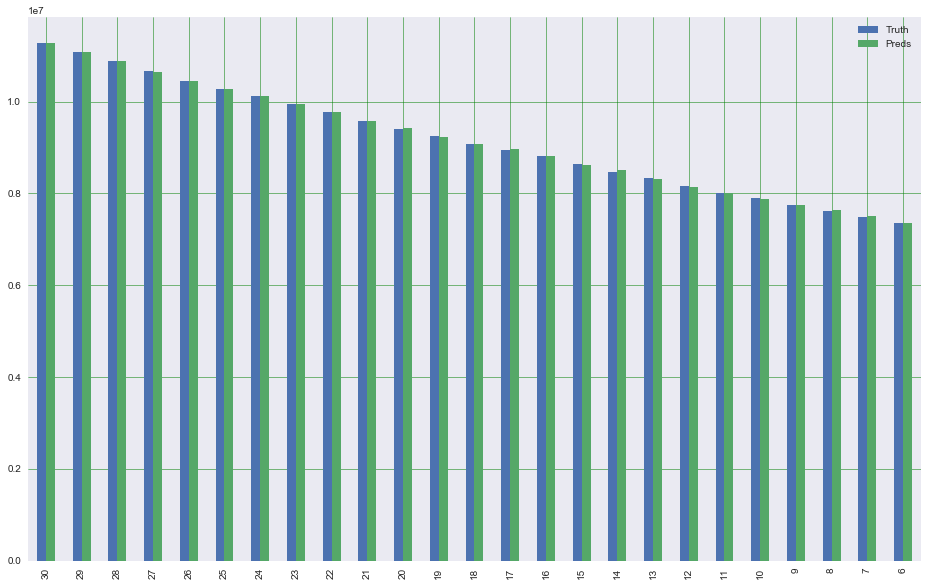

In [13]:
df1 = test_df.sort_values(by=['Truth', 'Preds'], ascending=False).head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

### Make predictions on country data

In [14]:
country_data = confirmed["Germany"]
country_data

1/22/20         0
1/23/20         0
1/24/20         0
1/25/20         0
1/26/20         0
            ...  
6/30/20    195418
7/1/20     195893
7/2/20     196370
7/3/20     196780
7/4/20     197198
Name: Germany, Length: 165, dtype: int64

In [15]:
country_test_x, country_test_y = create_dataset(country_data, OPTIMAL_WINDOW)

In [16]:
country_predictions = lr_model.predict(country_test_x)

country_test_dic = {}
country_test_dic["Truth"] = country_test_y
country_test_dic['Preds'] = country_predictions
country_test_df = pd.DataFrame(country_test_dic)

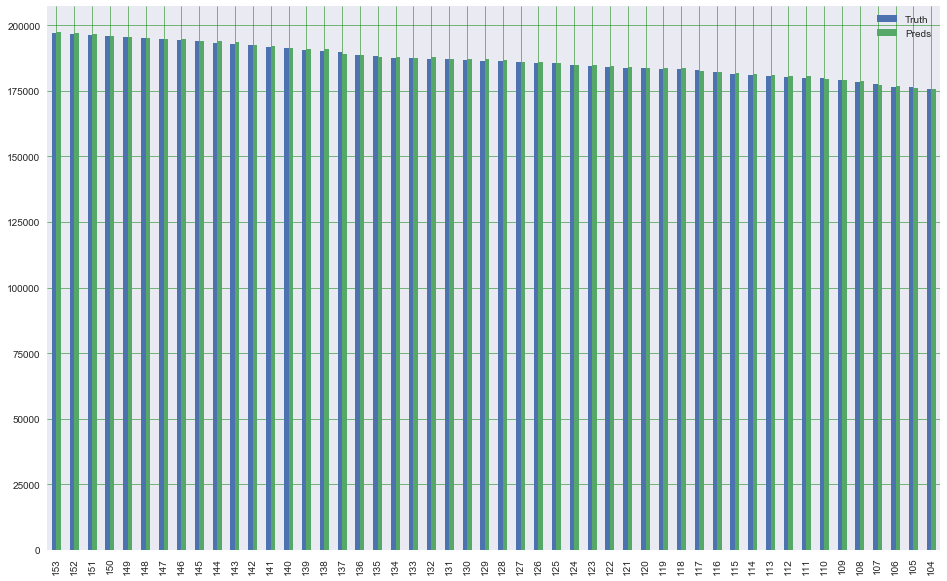

In [17]:
df_country = country_test_df.sort_values(by=['Truth', 'Preds'], ascending=False).head(50)
df_country.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

### Savel model

In [18]:
import joblib

#save model
joblib.dump(lr_model, 'corona_model.pkl') 

['corona_model.pkl']